In [1]:
import os
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

In [2]:
emob_path = ("/home/kilian/rli/PC50/storage/open_bea_calculations_v4"
            "/edisgo_files/{}/ego100/dumb/electromobility/charging_processes.csv")

ts_dir = "/home/kilian/rli/PC50/storage/open_bea_calculations_v4/edisgo_files/{}/ego100/{}/timeseries"

f_gen = "generators_active_power.csv"
f_load = "loads_active_power.csv"

grid_ids = [176, 177, 1056, 1690, 1811, 2534]

strategy = "dumb"

f_result = "ev_demand_load_and_gen_per_grid.csv"

In [3]:
try:
    results_df = pd.read_csv(
        f_result, index_col=0)
except:
    eta_cp = 0.9

    columns = ["generation", "load", "ev_demand", "ev_demand_private", "ev_demand_flex"]

    results_df = pd.DataFrame(data=0., index=grid_ids, columns=columns)

    for grid_id in tqdm(grid_ids):
        # calculate generation and load
        grid_ts_dir = ts_dir.format(grid_id, strategy)

        df = pd.read_csv(os.path.join(
            grid_ts_dir, f_gen), index_col=0, parse_dates=True, nrows=0)

        dtypes = {col: "float32" for col in df.columns}

        generation = pd.read_csv(os.path.join(
            grid_ts_dir, f_gen), index_col=0, parse_dates=True, dtype=dtypes).sum().sum() / 4

        df = pd.read_csv(os.path.join(
            grid_ts_dir, f_load), index_col=0, parse_dates=True, nrows=0)

        dtypes = {col: "float32" for col in df.columns}

        load = pd.read_csv(os.path.join(
            grid_ts_dir, f_load), index_col=0, parse_dates=True, dtype=dtypes).sum().sum() / 4

        # calculate charging demand
        grid_emob_path = Path(emob_path.format(grid_id))

        df_charging = pd.read_csv(
            grid_emob_path, index_col=0)

        df_charging = df_charging.loc[
            df_charging.park_start < 8760*4]

        df_charging = df_charging.assign(
            chargingdemand=df_charging.chargingdemand.divide(eta_cp))

        total_charging_demand = df_charging.chargingdemand.sum() / 1000

        df_private_charging = df_charging.loc[
            df_charging.use_case == "private"]

        private_charging_demand = df_private_charging.chargingdemand.sum() / 1000

        df_flex_charging = df_private_charging.assign(
            given_time=df_private_charging.park_end - df_private_charging.park_start,
            minimum_charging_time=(
                df_private_charging.chargingdemand / df_private_charging.netto_charging_capacity.divide(4)).apply(
                np.ceil).astype(int))

        df_flex_charging = df_flex_charging.loc[
            df_flex_charging.given_time > df_flex_charging.minimum_charging_time]

        flex_charging_demand = df_flex_charging.chargingdemand.sum() / 1000

        results_df.loc[grid_id] = [generation, load, total_charging_demand, private_charging_demand, flex_charging_demand]
    
    results_df.to_csv(f_result)

In [4]:
# charging profile data
f_cps = "charging_points_active_power.csv"

strategies = ["dumb", "reduced", "residual"]

grid_id = 176

f_result_charging_profile = "charging_profile.csv"

In [5]:
try:
    charging_profile_df = pd.read_csv(
        f_result_charging_profile, index_col=0, parse_dates=True)
except:
    for count, strategy in tqdm(enumerate(strategies)):
        strategy_ts_dir = ts_dir.format(grid_id, strategy)

        cps_df = pd.read_csv(os.path.join(
            strategy_ts_dir, f_cps), index_col=0, parse_dates=True)

        cps_df = cps_df.sum(axis=1).to_frame(name=strategy)

        if count == 0:
            charging_profile_df = cps_df.copy()
        else:
            charging_profile_df = charging_profile_df.merge(
                cps_df, how="left", left_index=True, right_index=True)
    
    charging_profile_df.to_csv(
        f_result_charging_profile)

In [6]:
len_week = 24*4

columns = charging_profile_df.columns.tolist()

columns.extend(col + "_std" for col in charging_profile_df.columns)

mean_charging_profile_df = pd.DataFrame(
    data=0., index=range(len_week), columns=columns)

for n in range(len_week):
    charging_profile_df_slice = charging_profile_df.iloc[
        n::len_week, :]
    
    vals = charging_profile_df_slice.mean().tolist()
    
    vals.extend(charging_profile_df_slice.std().tolist())
    
    mean_charging_profile_df.loc[n] = vals

# Plots

In [7]:
import matplotlib as mpl
import seaborn as sns
import locale
# Set to German locale to get comma decimal seperator
# Check with "locale -a" if "de_DE.utf8" is installed on your system
# Installation guide: https://ubuntuforums.org/showthread.php?t=196414
locale.setlocale(
    locale.LC_NUMERIC, "de_DE.utf8")

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import rgb2hex

# Tell matplotlib to use the locale
plt.rcParams['axes.formatter.use_locale'] = True

In [8]:
def RGB_to_hex(red, green, blue):
    """Return color as #rrggbb for the given color values."""
    return '#%02x%02x%02x' % (red, green, blue)

In [9]:
# Plot parameters
# Style
style = "whitegrid"
# Figure sizes
standard_sizes = {
    "a4portrait": (8.27, 11.69),
    "a4landscape": (11.69, 8.27),
    "a5portrait": (5.8, 8.3),
    "a5landscape": (8.3, 5.8),
}
# Font parameters
font = "sans-serif"
font_scale = 1.5
# Figure aesthetics
grid_linestyle = "--"
yticks = True
xticks = True
# Colors
palette = sns.color_palette("colorblind")

rgb_grid = (200, 200, 200)
rgb_labels = (0, 0, 0)

hex_grid = RGB_to_hex(*rgb_grid)
hex_labels = RGB_to_hex(*rgb_labels)

palette

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [10]:
# Set seaborn parameters
rc_theme = {
    "grid.linestyle":grid_linestyle,
    "ytick.left":yticks,
    "xtick.bottom":xticks,
    "ytick.color":hex_grid,
    "ytick.labelcolor":hex_labels,
    "xtick.color":hex_grid,
    "xtick.labelcolor":hex_labels,
    "grid.color":hex_grid,
}

sns.set_theme(
    style=style, font=font, font_scale=font_scale, palette=palette, rc=rc_theme)

In [11]:
figure_export_as = ["png", "jpg"]
export_dir = "/home/kilian/rli/rl-institut/05_Temp/Kilian/open_bea/plots"

## Plot flex EV demand per load and gen

In [12]:
ev_demand_per_gen_and_load_df = (
    results_df.ev_demand / results_df.generation).to_frame(name="ev_demand_per_gen")
ev_demand_per_gen_and_load_df = ev_demand_per_gen_and_load_df.assign(
    ev_demand_per_load=results_df.ev_demand / results_df.load)
ev_demand_per_gen_and_load_df *= 100
ev_demand_per_gen_and_load_df = ev_demand_per_gen_and_load_df.assign(
    kind="total")

flex_ev_demand_per_gen_and_load_df = (
    results_df.ev_demand_flex / results_df.generation).to_frame(name="ev_demand_per_gen")
flex_ev_demand_per_gen_and_load_df = flex_ev_demand_per_gen_and_load_df.assign(
    ev_demand_per_load=results_df.ev_demand_flex / results_df.load)
flex_ev_demand_per_gen_and_load_df *= 100
flex_ev_demand_per_gen_and_load_df = flex_ev_demand_per_gen_and_load_df.assign(
    kind="flex")

ev_demand_per_gen_and_load_df = ev_demand_per_gen_and_load_df.append(flex_ev_demand_per_gen_and_load_df)

In [13]:
sorting_dict = {
    176: 3,
    177: 4,
    1056: 2,
    1690: 0,
    1811: 1,
    2534: 5}

ev_demand_per_gen_and_load_df = ev_demand_per_gen_and_load_df.sort_index(
    key=lambda x: x.map(sorting_dict))

In [14]:
kind_dict = {
    176: "PV",
    177: "L",
    1056: "PV",
    1690: "W",
    1811: "W",
    2534: "L"}

naming_dict = {key: f"$\mathregular{{{key}_{{{kind_dict[key]}}}}}$"
               for key in ev_demand_per_gen_and_load_df.index}
naming_dict

{1690: '$\\mathregular{1690_{W}}$',
 1811: '$\\mathregular{1811_{W}}$',
 1056: '$\\mathregular{1056_{PV}}$',
 176: '$\\mathregular{176_{PV}}$',
 177: '$\\mathregular{177_{L}}$',
 2534: '$\\mathregular{2534_{L}}$'}

In [15]:
def show_values_on_bars(axs, extra_space=0):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = (p.get_y() + p.get_height()) + extra_space
            value = '{:.1f}'.format(p.get_height()).replace(".", ",")
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [16]:
for count, col in enumerate(ev_demand_per_gen_and_load_df.columns[:2]):
    print(col)

ev_demand_per_gen
ev_demand_per_load


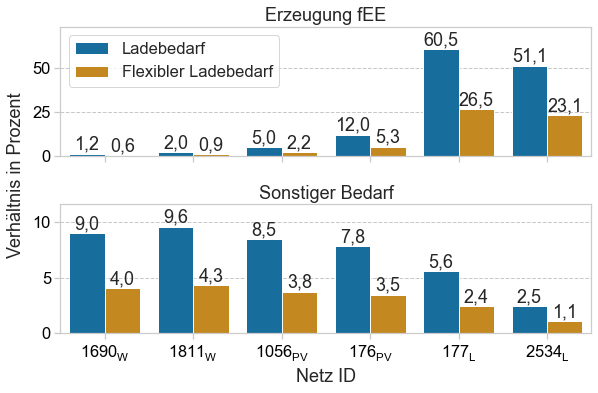

In [17]:
fig, axs = plt.subplots(
    2, 1, figsize=standard_sizes["a5landscape"], sharex=True)

for count, col in enumerate(ev_demand_per_gen_and_load_df.columns[:2]):
    plot_df = ev_demand_per_gen_and_load_df[[col, "kind"]].reset_index()#.sort_values(by="kind")
    
    ax = axs[count]
    
    sns.barplot(
        x="index", y=col, hue="kind", data=plot_df, order=plot_df["index"].unique(), ax=ax)
    
    ylim = ax.get_ylim()
    
    ylim = (ylim[0], ylim[1]*1.15)
    
    ax.set_ylim(ylim)
    
    ax.set_ylabel(None)
    
    show_values_on_bars(
        ax, extra_space=plot_df[col].max()/25)
    
    if count == 0:
        ax.set_xlabel(None)
        ax.set_title("Erzeugung fEE")
        
        ax.legend().set_title('')
        
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            handles=handles, labels=["Ladebedarf", "Flexibler Ladebedarf"])
    
    if count == 1:
        ax.set_xlabel("Netz ID")
        ax.set_title("Sonstiger Bedarf")
        
        labels = [naming_dict[int(item.get_text())] for item in ax.get_xticklabels()]
        
        ax.set_xticklabels(labels)
        
        ax.get_legend().remove()
        
fig.text(-0.01, 0.55, "Verhältnis in Prozent", va="center", rotation="vertical")

plt.tight_layout()

for kind in figure_export_as:
    plt.savefig(
        os.path.join(export_dir, f"ev_demand_per_gen_and_load.{kind}"),
        dpi=450, bbox_inches="tight")
    
plt.show()

## EV profile per strategy

In [18]:
import datetime

In [19]:
new_labels = ["Ungesteuert", "Reduziert", "Residual"]
new_labels2 = ["Reduziert", "Residual"]

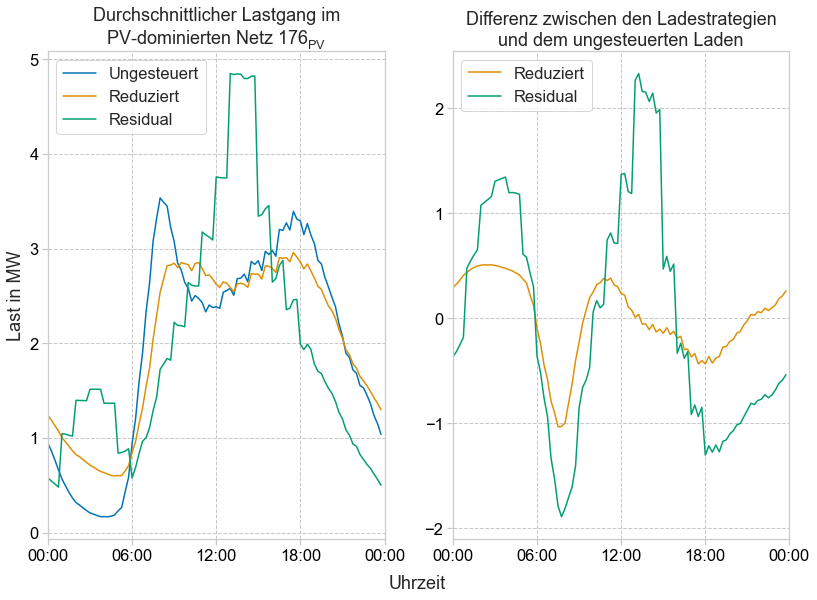

In [20]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=standard_sizes["a4landscape"], sharex=True, sharey=False)

plot_df = mean_charging_profile_df.copy()

# ax1
sns.lineplot(
    data=plot_df.iloc[:, :3], ax=ax1, dashes=["" for i in range(3)])

ax1.set_xlabel(None)
ax1.set_ylabel("Last in MW")
ax1.set_title("Durchschnittlicher Lastgang im\nPV-dominierten Netz $\mathregular{176_{PV}}$")

max_xtick = len(plot_df)

ax1.set_xticks(range(0, max_xtick+1, int(max_xtick/4)))
ax1.set_xticklabels(
    (datetime.datetime(2000, 1, 1, 0, 0) + datetime.timedelta(hours=i)).strftime("%H:%M")
    for i in range(0, 25, int(24/4)))

ax1.set_xlim((plot_df.index.min(), plot_df.index.max()+1))

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(
    handles=handles, labels=new_labels)

# ax2
plot_df = mean_charging_profile_df[["reduced", "residual"]] - mean_charging_profile_df[["dumb", "dumb"]].values

sns.lineplot(
    data=plot_df, ax=ax2, palette=palette[1:3], dashes=["" for i in range(2)])

ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.set_title("Differenz zwischen den Ladestrategien\nund dem ungesteuerten Laden")

max_xtick = len(plot_df)

ax2.set_xticks(range(0, max_xtick+1, int(max_xtick/4)))
ax2.set_xticklabels(
    (datetime.datetime(2000, 1, 1, 0, 0) + datetime.timedelta(hours=i)).strftime("%H:%M")
    for i in range(0, 25, int(24/4)))

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(
    handles=handles, labels=new_labels2)

fig.text(0.51, -0.01, "Uhrzeit", ha="center")

plt.tight_layout()

for kind in figure_export_as:
    plt.savefig(
        os.path.join(export_dir, f"mean_ev_load_per_charging_strategy.{kind}"),
        dpi=450, bbox_inches="tight")

plt.show()